# Control Board

In [1]:
%load_ext autoreload
%autoreload 2

import sys  
import pickle 
import gc

sys.path.insert(0, '/data/geodyn_proj/pygeodyn/pygeodyn_develop/')
from PYGEODYN_Plot import *


In [2]:
global_path = '/data/zach_work/Paper2022_assessment/runsetting_PhysicalCDasFixedValue/'
dir_save = '/data/data_geodyn/results/icesat2/Paper2022_PhysicalCD/SavedResults/'
dir_save_camel = '/data/data_geodyn/results/icesat2/Paper2022_PhysicalCD/CAMEL/'
plot_dir = '/data/zach_work/Paper2022_assessment/plots/'

#####----------------------------------------------------------------------------------
run_list = [  
               'msis2'      ,   
               'tiegcm_oc'  ,
               'jb2008'     ,
               'hasdm_oc'   ,
               'gitm'       ,           
               'dtm2020_o'  ,
               'ctipe_oc'   ,
           ]



#####----------------------------------------------------------------------------------
##### Choose a Stage:
# STAGE = '1_Calculate_DRIA_CD'
STAGE = '2_RunGEODYN_with_PhysicalFixedCD'
# STAGE = '3_RunGEODYN_AdjustCDforBias'
# STAGE = '4_GetMeanCDfromAdjustment'
# STAGE = '5_RunGEODYN_FixedMeanCD'



#####----------------------------------------------------------------------------------
##### Choose if GEODYN should be Re-run:
# Logic_RUN = True
Logic_RUN = False
#####----------------------------------------------------------------------------------
save_plot_flag = False
#####----------------------------------------------------------------------------------
Logic_makeCSV = False

####
Logic_read_pickles = False


## Read GEODYN

In [3]:
%load_ext autoreload
%autoreload 2

import sys  
import pickle 
import gc
import os

if Logic_read_pickles:
    sys.path.insert(0, '/data/geodyn_proj/pygeodyn/pygeodyn_develop/')
    from PYGEODYN import Pygeodyn


    if STAGE == "1_Calculate_DRIA_CD":
        settings_dir = 'DRIAruns/'
        runtype = '_DRIA.yaml'
        pickleName= '_2week_DRIA.pkl'


    elif STAGE== "2_RunGEODYN_with_PhysicalFixedCD":
        runtype = '_BWDRAG_Cd2.5.yaml'    
        settings_dir = 'CD_2.5/'
        pickleName= '_2week_CD2.5.pkl'


    elif STAGE== "3_RunGEODYN_AdjustCDforBias":
        runtype = '_BWDRAG_adjustCD.yaml'    
        settings_dir = 'Adjust_for_bias/'
        pickleName= '_2week_CDadjust.pkl'

    elif STAGE== "4_GetMeanCDfromAdjustment":
        runtype = '_BWDRAG_adjustCD.yaml'    
        settings_dir = 'Adjust_for_bias/'
        pickleName= '_2week_CDadjust.pkl'

    elif STAGE== "5_RunGEODYN_FixedMeanCD":
        runtype = '_BWDRAG_FixedMeanCD.yaml'    
        settings_dir = 'Adjust_for_bias/'
        pickleName= '_2week_FixedMeanCD.pkl'


    else:
        sys.exit(0)

    #####################################################
    ###### RUN GEODYN
    ###### -----------------------------------------------
    if Logic_RUN:
        for i,model in enumerate(run_list):   
            run_settings = global_path+settings_dir+ ''+model+runtype
            ### Load the data into an object
            RunObject = Pygeodyn(run_settings)
            RunObject.RUN_GEODYN()
            RunObject = 0
            gc.collect() 
    # sys.exit(0)

    ###### -----------------------------------------------


    for i,model in enumerate(run_list):     

        pickle_file = dir_save+model+pickleName

        if not os.path.exists(pickle_file):
            print('Must create pickle file...')
            print('   ',  pickle_file)
            print('   ', 'Reading Geodyn Data')

            run_settings = global_path+settings_dir+ ''+model+runtype
            ### Load the data into an object
            Obj = Pygeodyn(run_settings)
            Obj.getData_BigData_lowmemory()
            gc.collect()

            #### Pickle the object to save it
            print('   ', 'Saving pickle')
            filehandler = open(pickle_file, 'wb') 
            pickle.dump(Obj, filehandler)
            filehandler.close()
            Obj = 0
            print('   ', 'Saved pickle')

    Obj_Geodyn = {}
    for i,model in enumerate(run_list):     
        ### Load the data if the pickles exist
        print()
        print()
        gc.collect()

        pickle_file = dir_save+model + pickleName

        filehandler = open(pickle_file, 'rb') 
        Obj_Geodyn[model] = pickle.load(filehandler)
        filehandler.close()
        print('Loaded data from pickle... ', model)


    gc.collect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Obj_Geodyn['msis2'].__dict__.keys()

# 'Trajectory_orbfil', 'Density', 'Residuals_summary', 'Statistics', 'OrbitResids'

In [5]:
# Obj_Geodyn['msis2'].__dict__['OrbitResids']['2018.313.01']['resids']['Date']

In [6]:
# print(Obj_Geodyn['msis2'].__dict__['Density']['2018.313.01']['Date'][8683])
# print(Obj_Geodyn['msis2'].__dict__['Density']['2018.313.01']['Date'][8684])

# print(Obj_Geodyn['msis2'].__dict__['Density']['2018.313.01']['rho (kg/m**3)'][8683])
# print(Obj_Geodyn['msis2'].__dict__['Density']['2018.313.01']['rho (kg/m**3)'][8684])

In [7]:
# print(Obj_Geodyn['msis2'].__dict__['Density']['2018.313.01'])

In [8]:
# Obj_Geodyn['msis2'].__dict__['OrbitResids']['2018.313.01']['resids']['Date'][0]


In [9]:
# timesList[index_date]
# for ii,key2 in enumerate(Obj_Geodyn['msis2'].__dict__['Density']):
#     print(key2)
    
    
# #     print(Obj_Geodyn['msis2_p1'].__dict__['Density'][key2])
    

# Save data to CSVs

What data is needed for the Assessment Visualization in CAMEL:
  
  1. In-track residual   
  2. Density  
  3. Lon
  4. Lat
  5. Alt 

In [10]:
if Logic_makeCSV:
    import os
    append_headers = True      
    
    for imodel in run_list:
        print('\n',imodel)

        obj_m1 = Obj_Geodyn[imodel]
        filename = dir_save_camel+'TwoWeeks_FixedCD2.5_'+imodel+'.csv'

        ### Delete the existing files so they append cleanly
        if os.path.exists(filename):
            os.remove(filename)

        den_list   = []
        date_list  = []
        resid_list = []
        lon_list   = []
        lat_list   = []
        alt_list   = []
        
        ### Loop through the arcs and append the datasets for each arc into CSV files
        for ii,arc in enumerate(obj_m1.__dict__['global_params']['arc_input']):

            arc =arc+'.01'
            print(arc)
            import pandas as pd

            ### ----------------------------------------------------------------------------------
            ### SAVE DENSITY at same cadence as the T RESIDUALS
            ##
            ####   Find the datetime values in the density dataset that 
            ####       are closest to those in the residual datset.
            ####   The two sets have different cadences 
            ####       density is the integration step size (10sec)
            ####       orbfil is the output size (2min)

            def nearest(items, pivot):
                return min(items, key=lambda x: abs(x - pivot))

            timesList = pd.to_datetime(obj_m1.__dict__['Density'][arc]['Date'])
            vals  = np.arange(obj_m1.__dict__['Density'][arc].index[0],obj_m1.__dict__['Density'][arc].index[-1]+1)
            df = obj_m1.__dict__['Density'][arc].set_index('Date',drop=False ) 
            df['i_vals'] = vals
            for itime,timeCheck in enumerate(pd.to_datetime(obj_m1.__dict__['OrbitResids'][arc]['resids']['Date'])):

                date_nearstart = nearest(pd.to_datetime(df['i_vals'].index), timeCheck)
                index_date = df['i_vals'][date_nearstart].min()

                time_near = timesList[index_date]


                if np.abs((timeCheck - time_near).total_seconds()) < 10:
            #         print(timesList[index_date])
            #         print(obj_m1.__dict__['Density']['2018.313.01']['rho (kg/m**3)'][index_date])

                    date_list.append(timeCheck)
                    den_list.append(obj_m1.__dict__['Density'][arc]['rho (kg/m**3)'][index_date])
                    resid_list.append(obj_m1.__dict__['OrbitResids'][arc]['resids']['T'][itime])
                    
                    lon_list.append(obj_m1.__dict__['Density'][arc]['Lon'][index_date])
                    lat_list.append(obj_m1.__dict__['Density'][arc]['Lat'][index_date])
                    alt_list.append(obj_m1.__dict__['Density'][arc]['Height (meters)'][index_date])

                else:
                    print('THE TWO TIMES ARE FAR APART')
                    print('     timeCheck, time_near: ', timeCheck, time_near)

                    den_list.append(np.nan)
                    date_list.append(index_date)
                    resid_list.append(obj_m1.__dict__['OrbitResids'][arc]['resids']['T'][itime])
                    lon_list.append(np.nan)
                    lat_list.append(np.nan)
                    alt_list.append(np.nan)



        ### Convert to dictionaries then dataframes
        data = pd.DataFrame.from_dict({"Date"       : date_list,
                                       "Lon"        : lon_list,
                                       "Lat"        : lat_list,
                                       "Alt"        : alt_list,
                                       "Density"    : den_list,
                                       "T_residual" : resid_list
                                      },  
                                       orient='columns')



        data.to_csv( path_or_buf = filename,
                     sep=',',
                     mode='a',
                     #
                     index_label='Index',
                     header=append_headers,
                     index=True,
                              )

#     fig  = make_subplots(
#         rows=2, cols=1,
#         subplot_titles=(['Density (kg/m^3)'     ,
#                          'T Residuals (m)'     ,
#                         ]),
#         vertical_spacing = 0.15,
#         horizontal_spacing = 0.05,
#         shared_xaxes=False)

#     ################S#######################################
#     font_dict=dict(family='Arial',size=14,color='black')
#     #######################################################



#     fig.add_trace(go.Scattergl(x=date_list,
#                                y=den_list,
#                                ### name= model_m1,
#                                mode='markers',
#                                opacity=1,
#     #                                marker=dict(color=col,size=2),
#                                showlegend=False), row=1, col=1)
#     fig.add_trace(go.Scatter(x=date_list,
#                                y=resid_list,
#                                ### name= model_m1,
#                                mode='markers',
#                                opacity=1,
#                                showlegend=False), row=2, col=1)
#     fig.update_yaxes( 
#                      type="log", 
#                      exponentformat= 'power',row=1, col=1)
#     fig.update_yaxes(       exponentformat= 'power',row=2, col=1)


#     fig.show(config=dict({
#                 'displayModeBar': False,
#                 'responsive': False,
#                 'staticPlot': True,
#                 'displaylogo': False,
#                 'showTips': False,
#                 }))




# Read data back in from CSVs

In [11]:
csv_dicts = {}

for imodel in run_list:
#     obj_m1 = Obj_Geodyn[imodel]
    filename = dir_save_camel+'TwoWeeks_FixedCD2.5_'+imodel+'.csv'


    csv_dicts[imodel] = pd.read_csv(filename, sep=',')



In [12]:
csv_dicts['msis2']

,Index,Date,Lon,Lat,Alt,Density,T_residual
0,0,2018-11-09 00:03:00,214.1570,18.3499,482598.810,2.776733e-13,-109.828138
1,1,2018-11-09 00:05:00,213.3442,26.0247,483119.842,2.612394e-13,-109.188445
2,2,2018-11-09 00:07:00,212.4879,33.6908,484119.161,2.414354e-13,-108.549828
3,3,2018-11-09 00:09:00,211.5621,41.3459,485467.864,2.195699e-13,-107.908375
4,4,2018-11-09 00:11:00,210.5233,48.9881,487017.353,1.968359e-13,-107.260235
...,...,...,...,...,...,...,...
10765,10765,2018-11-23 23:49:00,207.7572,-5.0594,484678.703,2.378216e-13,-77.752489
10766,10766,2018-11-23 23:51:00,206.9884,2.6219,483323.865,2.394721e-13,-78.270854
10767,10767,2018-11-23 23:53:00,206.2162,10.3047,482623.926,2.339460e-13,-78.813471
10768,10768,2018-11-23 23:55:00,205.4305,17.9854,482563.278,2.225353e-13,-79.382505


In [40]:
arc_list = ['2018.313', '2018.314', '2018.315', '2018.316', '2018.317',
            '2018.318', '2018.319', '2018.320', '2018.321', '2018.322',
            '2018.323', '2018.324', '2018.325', '2018.326', '2018.327' ]  



2018-11-09 12:00:00
2018-11-10 12:00:00
2018-11-11 12:00:00
2018-11-12 12:00:00
2018-11-13 12:00:00
2018-11-14 12:00:00
2018-11-15 12:00:00
2018-11-16 12:00:00
2018-11-17 12:00:00
2018-11-18 12:00:00
2018-11-19 12:00:00
2018-11-20 12:00:00
2018-11-21 12:00:00
2018-11-22 12:00:00
2018-11-23 12:00:00


In [37]:
rms_intrack_fulltimeAvg

42.10795312600123

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


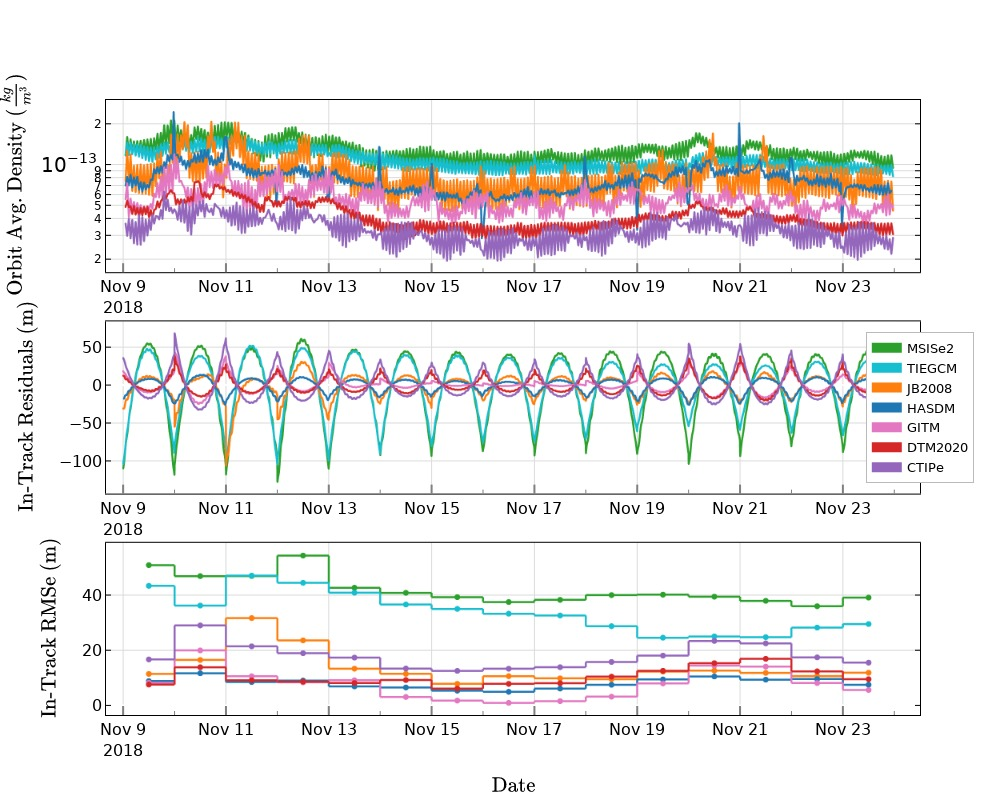

In [44]:
%load_ext autoreload
%autoreload 2



if STAGE == '2_RunGEODYN_with_PhysicalFixedCD':
    
    def COMPUTE_orbit_average_InputParam(DFin,  param_str):
        '''Compute the orbit average'''
        DFin = DFin.reset_index(drop=True)  
        lat = np.asarray(DFin['Lat'][:])
        time_pd = pd.to_datetime(DFin['Date'][:])
        i = np.nonzero( lat[1:]*lat[0:-1]  <  np.logical_and(0 , lat[1:] > lat[0:-1] )  )
        i = i[0]

        d_avg = np.zeros(np.size(i))
        height_avg = np.zeros(np.size(i))

        time_avg = []

        for j in range(np.size(i)-1):
            d_avg[j]      = np.mean(DFin[param_str][i[j] : i[j+1]-1  ]  )
            t1 = pd.to_datetime(time_pd[ i[j]    ])
            t2 = pd.to_datetime(time_pd[ i[j+1]-1])
            datemiddle = pd.Timestamp(t1) + (pd.Timestamp(t2) - pd.Timestamp(t1)) / 2
            time_avg.append(datemiddle)

        param_avg          = d_avg
        return(time_avg, param_avg )

    
    def COMPUTE_RMS_intrack(DFin, arc_list):
        #-------------------------------------------------- #
        def STATS_residuals(residuals):                     #
            import numpy as np                              #
            n = np.size(residuals)                          #
            mean = (1/n)*(np.sum(residuals))                #
            variance = (1/n)*(np.sum(np.square(residuals))) #
            rms = np.sqrt(variance)                         #
            rms_about_zero = np.sqrt((n/(n-1))*variance)    #
            return(mean,rms,rms_about_zero)                 #
        #-------------------------------------------------- #
        
        rms_intrack_DailyAvg = [] 
        for idate, date in enumerate(arc_list):
            date_val = pd.to_datetime( str(date), format='%Y.%j')
            date_mask = np.logical_and(pd.to_datetime(DFin['Date'].values).day_of_year>=date_val.day_of_year,
                                       pd.to_datetime(DFin['Date'].values).day_of_year<=date_val.day_of_year )
            (mean,rms,rms_about_zero) = STATS_residuals(DFin['T_residual'][date_mask])
            rms_intrack_DailyAvg.append(rms_about_zero)
        rms_intrack_fulltimeAvg = np.mean(rms_intrack_DailyAvg)
        return(rms_intrack_DailyAvg, rms_intrack_fulltimeAvg)
        
        
    def plot_from_csv(fig, plot_num, csv, model_name):
        ####  Get Plot Parameters for this model
        model_m1 = model_name
        col = get_plot_params(plot_num, model_m1)

#         dateplot = []
#         rms_totals = []
#         dateplot.append(pd.to_datetime(datetime.datetime(int(arc.split('.')[0]), 1, 1) + datetime.timedelta(int(arc.split('.')[1]))- datetime.timedelta(hours=12) ))
#         rms_totals.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])

        time_avg, Rho_OrbAvg = COMPUTE_orbit_average_InputParam(csv, 'Density')

        ### -----------------------------------------------------------------------------------------------------
        ###     DENSITY
        fig.add_trace(go.Scattergl(x=time_avg,
                                   y=Rho_OrbAvg,
                                       mode='markers+lines',
                                       opacity=1,
                                       marker=dict(color=col,size=2),
                                       line = dict(dash ='solid', color = col, width=2),
                                       showlegend=False), row=1, col=1)
        ### -----------------------------------------------------------------------------------------------------
        ###     In Track Residuals
        fig.add_trace(go.Scattergl(x=csv['Date'],
                                 y=csv['T_residual'],
                                     mode='markers+lines',
                                     opacity=1,
                                         marker=dict(color=col,size=2),
                                         line = dict(color=col,width=2),
                                     showlegend=False),
                                     secondary_y=False, row=2, col=1)
        ### -----------------------------------------------------------------------------------------------------
        ###     TOTAL RMS
        arc_list = ['2018.313', '2018.314', '2018.315', '2018.316', '2018.317',
                    '2018.318', '2018.319', '2018.320', '2018.321', '2018.322',
                    '2018.323', '2018.324', '2018.325', '2018.326', '2018.327' ]  
        
        dateplot = [pd.to_datetime( datetime.datetime(int(arc.split('.')[0]), 1, 1) + 
                                    datetime.timedelta(int(arc.split('.')[1]))      -
                                    datetime.timedelta(hours=12)) 
                                        for arc in arc_list]

        rms_intrack_DailyAvg, rms_intrack_fulltimeAvg = COMPUTE_RMS_intrack(csv, arc_list)
        fig.add_trace(go.Scattergl(x=dateplot,
                                   y=rms_intrack_DailyAvg,
                                     mode='markers+lines',
                                     opacity=1,
                                     marker=dict(color=col,size=6),
                                     line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                     showlegend=False),row=3, col=1)

        if plot_num == 2 or plot_num == 0:
            ###
            ### DENSITY AXIS
            fig.update_yaxes(title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
                             type="log", 
                             exponentformat= 'power',row=1, col=1)
            ###
            ### InTrack Residual Axis
            fig.update_yaxes( title=r"$\text{In-Track Residuals (m)}$",
    #                          range=yaxis3_range, 
                             exponentformat= 'power',row=2, col=1)
            ###
            ### RMS AXIS
            fig.update_yaxes( title=r"$\text{In-Track RMSe (m)}$" ,type="linear" , exponentformat= 'power',
    #                           range=yaxis4_range, 
                             row=3, col=1)
            ###
            ###  DATE on Final x-Axis only
            fig.update_xaxes(title=r"$\text{Date}$", 
                             range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                                    pd.to_datetime( "181124-120000", format='%y%m%d-%H%M%S')],
                             row=3, col=1)


        return(fig)
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------

    run_dict = { 
                  'msis2'    : 1  ,
                  'tiegcm_oc': 2  ,
                  'jb2008'   : 3  ,
                  'hasdm_oc' : 4 , 
                  'gitm'     : 5 , 
                  'dtm2020_o': 6 ,
                 'ctipe_oc'   : 7 ,
               }

    fig = make_subplots(rows=3, cols=1,
                        specs=[ [ {"secondary_y": False} ],
                                [ {"secondary_y": False} ],
                                [ {"secondary_y": False} ]],
                        vertical_spacing = 0.08,
                        shared_xaxes=True)




    for iplot,model in enumerate(run_list):
        fig = plot_from_csv(fig, iplot, csv_dicts[model], model )


    #######################################################
    font_dict=dict(family='Arial',size=16,color='black')
    #######################################################




    for i in [1,2,3]:
        fig.update_xaxes(### LINE at axis border
                          showline=True,
                          showticklabels=True,
                          linecolor='black',
                          linewidth=1,
                         ### Major ticks
                          ticks='inside',
                          tickfont=font_dict,
                          mirror=True,
                          tickwidth=2,
                          ticklen=9,
                          tickcolor='grey',
                          tick0="2018-11-9" ,
                          dtick=86400000.0*2,    # milliseconds in a day, every 7 days
                          #### Minor Ticks
                           minor=dict(
                             dtick=86400000.0, # milliseconds in a day
                             tickwidth=1,
                             ticklen=4,
                             tickcolor='grey',
                             ticks='inside'),
                          ### GRID
                           gridcolor='gainsboro',
                           gridwidth=1,
                           layer='above traces',
                           tickangle=0,
                           row=i, col=1)
        fig.update_yaxes(showline=True,      # add line at x=0
                             showticklabels=True,
                             linecolor='black',  # line color
                             linewidth=1,        # line size
                         ticks='inside',     # ticks outside axis
                         tickfont=font_dict, # tick label font
                         mirror='allticks',  # add ticks to top/right axes
                         tickwidth=1,      # tick width
                         tickcolor='black',  # tick color
                         gridcolor='gainsboro',
                         gridwidth=1,
                         layer='above traces',
                         row=i, col=1)


    fig = add_fancy_legend_noRMS(fig, run_dict)

    fig.update_layout(
                      autosize=False,    width=1000,    height=800,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=16)  # Increase size of subplot title

    fig.show(renderer="jpg",
             config=dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': False,
                'displaylogo': False,
                'showTips': False,
                }))

